A brain hemorrhage is a type of stroke. A brain hemorrhage is bleeding in or around the brain. It is a form of stroke. Causes of brain hemorrhage include high blood pressure (hypertension), abnormally weak or dilated (aneurysm) blood vessels that leak, drug abuse, and trauma. 

To make a brain hemorrhage diagnosis, your doctor will first ask about your brain bleed symptoms. Next, they'll work to locate the source of the bleeding. To do this, your doctor may order a CT scan, an MRI, or one of the following tests. But it is said that the MRI for the patients with hemorrhage is more dangerous as it can increase the intensity.

New technologies like artificial intelligence helps us to diagnose hemorrage in brain by using CT scan images of the brain. Here we have a dataset of images divided into train, validation and test set in two classes hemorrage and non-hemorrage. We will train convolution neural network to create a real time classification model to detect brain hemorrage.

In [1]:
from IPython.display import clear_output
clear_output()

In [ ]:
# Loading all necessary package
import os # Os package 
import cv2 # Computer vision openCV package
import imutils as imutils #imutils package
import numpy as np #Numpy Array for linear algebra
import pandas as pd #Pandas library import
import tensorflow as tf #Tensorflow package for Convolution Neural Network
from tqdm import tqdm  # Package for fast progress bar
import matplotlib.pyplot as plt #matplotlib package for plots
import matplotlib.image as mpimg #mpimg to plot images
from sklearn.metrics import accuracy_score, confusion_matrix #permormance metrics from scikit-learn
import seaborn as sn #Data visiualisation with seaborn
from sklearn.preprocessing import LabelBinarizer #Set labels into binary
from sklearn.model_selection import train_test_split # Train test split by scikit-learn
import plotly.graph_objs as go #plotly to graph objects
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.applications.vgg16 import VGG16, preprocess_input # VGG16 Transferlearning APIs
from keras import layers #layers from Keras
from keras.models import Model, Sequential #Model and Sequential from keras
from keras.optimizers import Adam,SGD # Optmisers like ADAM, SGD
from keras.callbacks import EarlyStopping # Earlystopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Imagedatagenerator from keras use to generate and label data by its directory
from keras.layers import Dense, Dropout, Flatten #Dense, Dropout and Flatten layers  
from keras.layers import Conv2D, MaxPooling2D, Conv3D, BatchNormalization #Convolution, MaxPooling2D, Conv3D, Batchnormalisation layer 
from tensorflow.keras.models import load_model #Load saved trainned models for taking out inferences 

# Setting some parameters in the beginning 
RANDOM_SEED = 1 # Seed for stable split
IMG_SIZE = (224, 224) # size of input image
IMG_PATH = "/content/drive/My Drive/Brain Tumor Images Dataset/" #Dataset folder

# Printing list of dataset in the directory
print(os.listdir(IMG_PATH)) 

# **Data Preperation**

We have Training, Test aand validation set of images. Every set is further divided into two class haemmorhage and non-haemmorage containing ct scan images of brain with blood clotting and without blood cloating.

In [3]:
Test_Path = IMG_PATH + "test_set/"
Training_Path = IMG_PATH + "training_set/"
Validation_Path = IMG_PATH + "validation_set/"

Total Number of images in each set classes

In [ ]:
def number_of_imgs(path):
    print(path)
    for value in os.listdir(path):
        print(value, "has", len(os.listdir(path + value)), "imgs")
    print('\n')
    
    
number_of_imgs(Test_Path)
number_of_imgs(Training_Path)
number_of_imgs(Validation_Path)

Creating Data frame to plot images from each set

In [5]:
# Function to create dataframe
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if hemmorhage than set if to 1 else 0
            hemmorhage = 1 if value.lower() == "hemmorhage_data" else 0
            data.append({"path": file_path, 'hemmorhage': hemmorhage})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

In [6]:
# Defining plotting function for images
%matplotlib inline
def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'YES' if row['hemmorhage'] == 1 else 'NO'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()

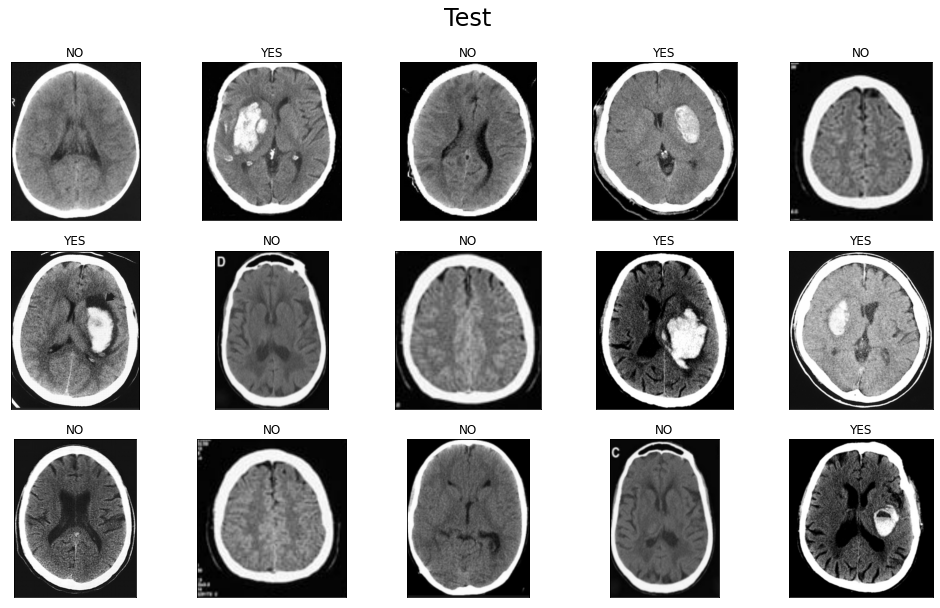

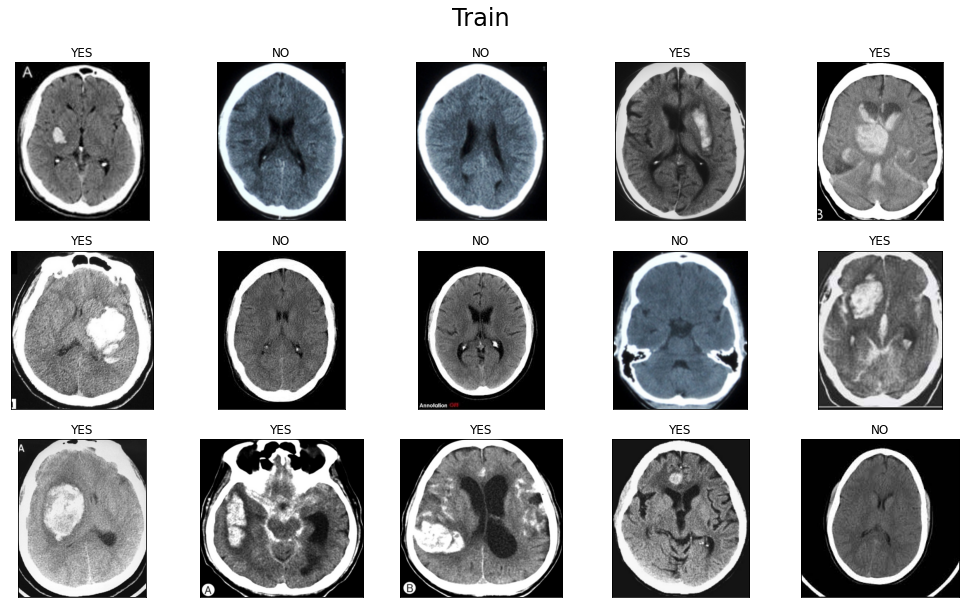

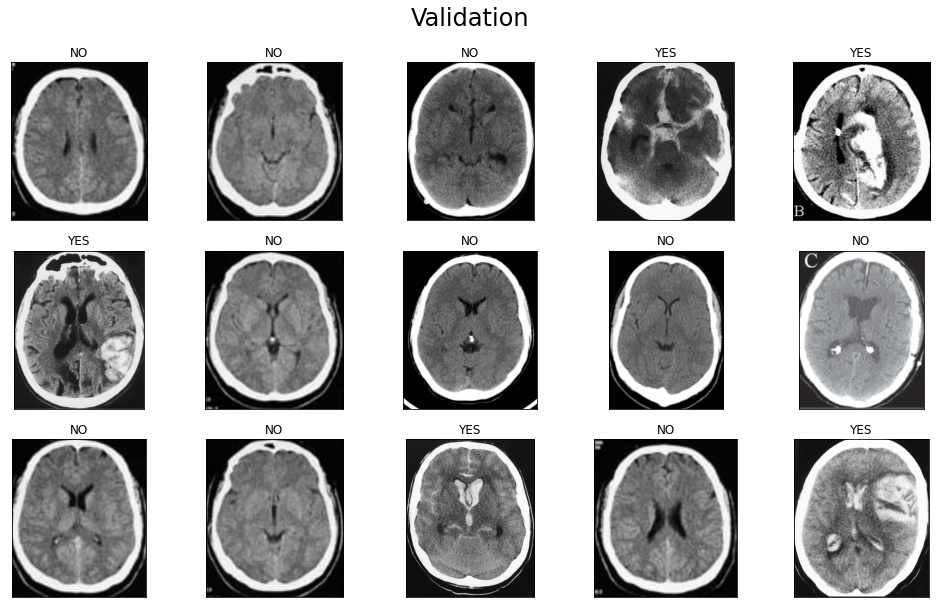

In [7]:
#Plotting 15 images from each 
plot_imgs("Test", create_dataframe(Test_Path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_Path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_Path).sample(15).reset_index(drop=True))

Cropping the rectangular image out of the images by finding the extreme points on the image. This function is using opencv to crop the image and converting it from RGB to Grayscale. Then applying gausian blur to make it sharper to predict.

In [8]:
# Defining crop image function
def crop_imgs(set_name, add_pixels_value=0):
    """Finds the extreme points on the image and crops the rectangular out of them"""
    set_new = []
    for img in set_name:
        img = cv2.imread(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        ext_left = tuple(c[c[:, :, 0].argmin()][0])
        ext_right = tuple(c[c[:, :, 0].argmax()][0])
        ext_top = tuple(c[c[:, :, 1].argmin()][0])
        ext_bot = tuple(c[c[:, :, 1].argmax()][0])

        add_pixels = add_pixels_value
        new_img = img[ext_top[1] - add_pixels:ext_bot[1] + add_pixels
        , ext_left[0] - add_pixels:ext_right[0] + add_pixels].copy()
        set_new.append(new_img)
        
    return np.array(set_new)

crop_imgs(create_dataframe(Test_Path)['path'])
crop_imgs(create_dataframe(Training_Path)['path'])
crop_imgs(create_dataframe(Validation_Path)['path'])

The clear_output()

The Convolution neural networks are special types of neural networks which are used for image recognition and classification mainly. Though it can be used for time series analysis and different other models as well.

CNNs work by selecting dominant features instead of pixels of an image to determe the images.

Following image shows the propagation in Convolution neural networks.






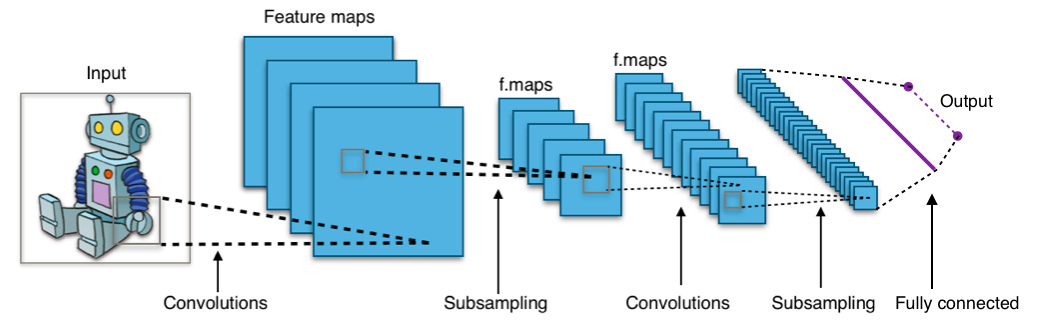

In [ ]:
model = tf.keras.models.Sequential([
# YOUR CODE HERE
    
])
model.compile(#your code here)
model.summary()

**Image Augumentation**

In [9]:
#Tensorflow Imagedatagenerator function used for image augumentation. 
train_datagen = ImageDataGenerator(
      rescale=1./255

      )
validation_datagen=ImageDataGenerator(rescale=1./255)

Loading images from the directory and applying image augumentation with binary class_mode

In [10]:
train_generator = train_datagen.flow_from_directory(
        )
validation_generator = validation_datagen.flow_from_directory(
        )

Found 140 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
#Model Fit
#callback the model once model reaches 90 percent accuracy
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

# Model Fit
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    callbacks=[callbacks])

# **Learning curves of Sigmoid CNN Model** 

In [ ]:
# loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["loss"])), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("sigmoid normal loss")

In [ ]:
# Accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["acc"])), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, len(history.history["acc"])), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("sigmoid normal accuracy")

# **Generalisation Real Time Performance of CNN sigmoid model**

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import datetime
uploaded=files.upload()
set_new=[]
for fn in uploaded.keys():
 
  # predicting images
  path='/content/'+ fn
  img = cv2.imread(path)
  img = cv2.resize(
                img,
                dsize=(224,224),
                interpolation=cv2.INTER_CUBIC
            )
  set_new.append(img)
images= np.array(set_new)
yp = model.predict(images)
print(yp)
title = "hemmorhage" if yp <= 0.5 else "non-hemmorhage"
cv2.putText(img,title, (1, 18), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)
cv2_imshow(img)

**Transfer Learning models for CNN model tunning and better performance**
VGG16 model for classification of brain tumor, we are trying to optimise classification performance. Transfer learning is the way by which we can transfer the weights from pretrained models to optmise our performance. These APIs are available with keras and imagenet datasets

In [ ]:
#Transfer Learning Model
# add preprocessing layer to the front of VGG

# don't train existing weights

# our layers - you can add more if you want


# create a model object
vggmodel=Model(inputs=vgg.input,outputs=prediction)
# view the structure of the model
vggmodel.summary()
# tell the model what cost and optimization method to use
vggmodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
# Model fit over VGG model for sigmoid output
r = vggmodel.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=100,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

**Learning Curves of VGG16 sigmoid model**

In [ ]:
# loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(r.history["loss"])), r.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(r.history["loss"])), r.history["val_loss"], label="val_loss")
plt.title("Training Loss vgg")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("sigmoid vgg loss")

In [ ]:
# Accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(r.history["acc"])), r.history["acc"], label="train_acc")
plt.plot(np.arange(0, len(r.history["acc"])), r.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("sigmoid vgg accuracy")

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import datetime
uploaded=files.upload()
set_new=[]
for fn in uploaded.keys():
 
  # predicting images
  path='/content/'+ fn
  #img=image.load_img(path, target_size=(224, 224))
  img = cv2.imread(path)
  img = cv2.resize(
                img,
                dsize=(224,224),
                interpolation=cv2.INTER_CUBIC
            )
  set_new.append(img)
images= np.array(set_new)
yp = vggmodel.predict(images)
print(yp)
title = "hemmorhage" if yp <= 0.5 else "non-hemmorhage"
cv2.putText(img,title, (1, 18), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)
cv2_imshow(img)

**Let's do it with the softmax as output function**
Softmax function provides probability of each class to be truth value. It is used for multiclass classifications.

In [ ]:
#construct model with softmax as the output layer activation function 
#Construct the model with 3 convolution layers and 512 units of fully connected dense layers
softmaxmodel = tf.keras.models.Sequential([
# YOUR CODE HERE
    
])
A=Adam(learning_rate=0.001)
softmaxmodel.compile(optimizer=A, loss='categorical_crossentropy', metrics=['acc'])
softmaxmodel.summary()

Generate the training and validation data as categorical class mode

In [25]:
#categorical train and valodation data generator
train_generator = train_datagen.flow_from_directory(
    
        )
validation_generator = validation_datagen.flow_from_directory(
        )

Found 140 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
#Fit the softmax model over training images 
history = softmaxmodel.fit_generator(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

**Learning Curves of Softmax CNN Model**

In [ ]:
#Loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["loss"])), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("normal loss")

In [ ]:
#Accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["acc"])), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, len(history.history["acc"])), history.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("Normal accuracy")

# **Real time generalisation performance of softmax cnn model**

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import datetime
uploaded=files.upload()
set_new=[]
for fn in uploaded.keys():
 
  # predicting images
  path='/content/'+ fn
  #img=image.load_img(path, target_size=(224, 224))
  img = cv2.imread(path)
  img = cv2.resize(
                img,
                dsize=(224,224),
                interpolation=cv2.INTER_CUBIC
            )
  set_new.append(img)
images= np.array(set_new)
yp = softmaxmodel.predict(images)
print(yp)
title = "hemmorhage" if yp[0][0] == 1.0 else "nonhemmorhage"
cv2.putText(img,title, (1, 18), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)
cv2_imshow(img)

**VGG16 model for optimised performance**

In [ ]:

# add preprocessing layer to the front of VGG

# don't train existing weights


# our layers - you can add more if you want
# create a model object

# view the structure of the model
vggsoftmaxmodel.summary()

# tell the model what cost and optimization method to use
vggsoftmaxmodel.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)


In [ ]:
#VGG16 softmax model fit  
r = vggsoftmaxmodel.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=100,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

**Learning Curve of VGG16 softmax models** 

In [ ]:
# loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(r.history["loss"])), r.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(r.history["loss"])), r.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("Vgg16")

In [ ]:
#Accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(r.history["accuracy"])), r.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(r.history["accuracy"])), r.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("Vgg16")

**Generalised real-time performance of VGG16 softmax model for brain tumor detection**

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import datetime
uploaded=files.upload()
set_new=[]
for fn in uploaded.keys():
 
  # predicting images
  path='/content/'+ fn
  #img=image.load_img(path, target_size=(224, 224))
  img = cv2.imread(path)
  img = cv2.resize(
                img,
                dsize=(224,224),
                interpolation=cv2.INTER_CUBIC
            )
  set_new.append(img)
images= np.array(set_new)
yp = vggsoftmaxmodel.predict(images)
print(yp)
title = "hemmorhage" if yp[0][0] >= 0.5 else "nonhemmorhage"
cv2.putText(img,title, (1, 18), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)
cv2_imshow(img)